In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import os

image_dir = '/content/drive/MyDrive/Colab Notebooks/raw/images'
image_paths = []

for root, _, files in os.walk(image_dir):
    for f in files:
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            image_paths.append(os.path.join(root, f))

print(f"Found {len(image_paths)} image files.")

Found 13901 image files.


In [9]:
def get_label_from_path(path, base_dir):
    relative_path = os.path.relpath(path, base_dir)
    class_name = relative_path.split(os.sep)[0]
    return class_name

base_dir = '/content/drive/MyDrive/Colab Notebooks/raw/images'




class_names_found = sorted(list(set(get_label_from_path(p, base_dir) for p in image_paths)))
label_map = {name: i for i, name in enumerate(class_names_found)}
labels = [label_map[get_label_from_path(p, base_dir)] for p in image_paths]

df = pd.DataFrame({'path': image_paths, 'label': labels})

print(f"Classes found: {class_names_found}")
print(f"Label map: {label_map}")
print(f"Total images: {len(df)}")
print("\nLabel distribution:")
print(df['label'].value_counts())

Classes found: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Label map: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Total images: 13901

Label distribution:
label
5    2500
1    2500
3    2315
4    2288
0    2214
2    2084
Name: count, dtype: int64


In [10]:
IMG_SIZE = (224, 224)

base_model = MobileNetV2(weights='imagenet', include_top=False,
                       input_shape=IMG_SIZE + (3,), pooling='avg')

feature_extractor_model = base_model
feature_extractor_model.trainable = False

print("Feature extractor model loaded.")

def extract_features(img_path, model):
    try:
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        features = model.predict(img_preprocessed, verbose=0)
        return features.flatten()
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None # Return None for bad images

all_features = []
valid_labels = []
valid_paths = []

print("Extracting features...")
for index, row in tqdm(df.iterrows(), total=len(df)):
    features = extract_features(row['path'], feature_extractor_model)
    if features is not None:
        all_features.append(features)
        valid_labels.append(row['label'])
        valid_paths.append(row['path'])

X = np.array(all_features)
y = np.array(valid_labels)

# Update DataFrame to only include valid images
df_valid = pd.DataFrame({'path': valid_paths, 'label': y})


print(f"\nFeature matrix shape after cleaning: {X.shape}")
print(f"Labels shape after cleaning: {y.shape}")
if X.shape[0] < len(df):
    print(f"Removed {len(df) - X.shape[0]} problematic images.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Feature extractor model loaded.
Extracting features...


100%|██████████| 13901/13901 [1:59:16<00:00,  1.94it/s]


Feature matrix shape after cleaning: (13901, 1280)
Labels shape after cleaning: (13901,)


Training features shape: (11120, 1280)
Testing features shape: (2781, 1280)

--- Training Baseline Logistic Regression (C=1) ---

Baseline Model Evaluation:
Accuracy: 0.9015
Weighted F1-Score: 0.9016
              precision    recall  f1-score   support

   cardboard       0.88      0.90      0.89       443
       glass       0.94      0.90      0.92       500
       metal       0.88      0.91      0.90       417
       paper       0.89      0.89      0.89       463
     plastic       0.89      0.91      0.90       458
       trash       0.93      0.90      0.91       500

    accuracy                           0.90      2781
   macro avg       0.90      0.90      0.90      2781
weighted avg       0.90      0.90      0.90      2781



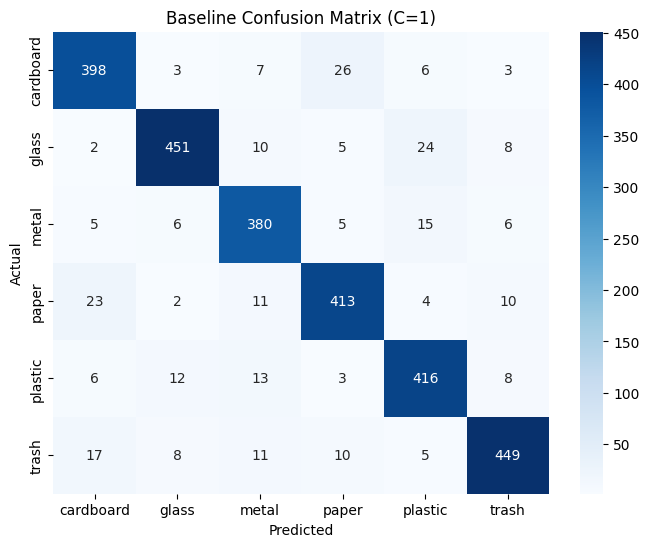


--- Tuning Logistic Regression using GridSearchCV ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters found: {'C': 0.01}
Best cross-validation accuracy: 0.8954

--- Evaluating Best Tuned Model (C=0.01) ---
Accuracy: 0.9079
Weighted F1-Score: 0.9080
              precision    recall  f1-score   support

   cardboard       0.90      0.91      0.90       443
       glass       0.92      0.91      0.91       500
       metal       0.89      0.91      0.90       417
       paper       0.89      0.90      0.90       463
     plastic       0.90      0.89      0.90       458
       trash       0.94      0.93      0.93       500

    accuracy                           0.91      2781
   macro avg       0.91      0.91      0.91      2781
weighted avg       0.91      0.91      0.91      2781



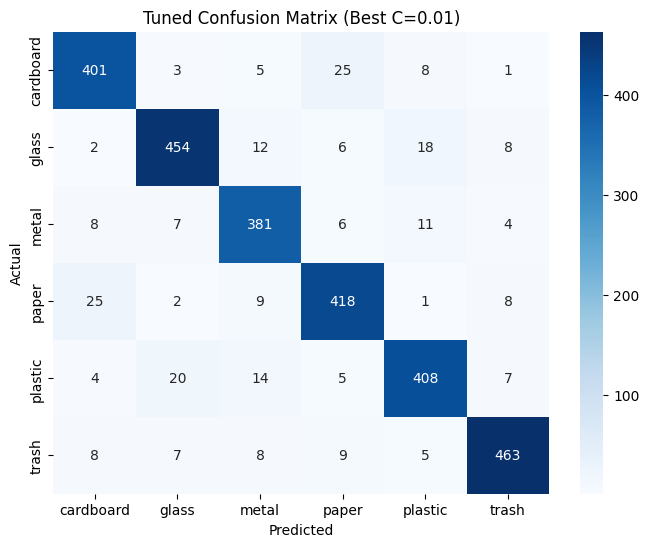


--- Evaluating Alternative Tuned Model (C=0.1) ---
Accuracy: 0.9083
Weighted F1-Score: 0.9085
              precision    recall  f1-score   support

   cardboard       0.89      0.90      0.89       443
       glass       0.95      0.92      0.93       500
       metal       0.89      0.92      0.91       417
       paper       0.89      0.90      0.89       463
     plastic       0.89      0.91      0.90       458
       trash       0.94      0.90      0.92       500

    accuracy                           0.91      2781
   macro avg       0.91      0.91      0.91      2781
weighted avg       0.91      0.91      0.91      2781


--- Comparison of Model Varieties ---
                     Accuracy        F1
Baseline (C=1)       0.901474  0.901604
Best Tuned (C=0.01)  0.907947  0.908019
Alternative (C=0.1)  0.908306  0.908452


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training features shape: {X_train_scaled.shape}")
print(f"Testing features shape: {X_test_scaled.shape}")

# --- Variety 1: Baseline Model ---
print("\n--- Training Baseline Logistic Regression (C=1) ---")
log_reg_base = LogisticRegression(random_state=42, max_iter=1000, C=1.0)
log_reg_base.fit(X_train_scaled, y_train)

y_pred_base = log_reg_base.predict(X_test_scaled)
print("\nBaseline Model Evaluation:")
accuracy_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base, average='weighted')
print(f"Accuracy: {accuracy_base:.4f}")
print(f"Weighted F1-Score: {f1_base:.4f}")
print(classification_report(y_test, y_pred_base, target_names=class_names_found, zero_division=0))

plt.figure(figsize=(8, 6))
cm_base = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_found, yticklabels=class_names_found)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Confusion Matrix (C=1)')
plt.show()


# --- Variety 2 & 3: Parameter Tuning (GridSearchCV) ---
print("\n--- Tuning Logistic Regression using GridSearchCV ---")
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg_tuned_model = LogisticRegression(random_state=42, max_iter=1000)

grid_search = GridSearchCV(log_reg_tuned_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

best_log_reg = grid_search.best_estimator_
best_C = grid_search.best_params_['C']

# --- Evaluate Variety 2: Best Tuned Model ---
print(f"\n--- Evaluating Best Tuned Model (C={best_C}) ---")
y_pred_tuned = best_log_reg.predict(X_test_scaled)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Weighted F1-Score: {f1_tuned:.4f}")
print(classification_report(y_test, y_pred_tuned, target_names=class_names_found, zero_division=0))

plt.figure(figsize=(8, 6))
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_found, yticklabels=class_names_found)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Tuned Confusion Matrix (Best C={best_C})')
plt.show()

# --- Evaluate Variety 3: Another C value (e.g., C=0.1 if it wasn't the best) ---
alt_C = 0.1
if best_C == alt_C: # If best C was 0.1, choose another one like 10
    alt_C = 10
    if best_C == alt_C: # If best C was also 10, maybe choose 0.01
        alt_C = 0.01

print(f"\n--- Evaluating Alternative Tuned Model (C={alt_C}) ---")
log_reg_alt = LogisticRegression(C=alt_C, random_state=42, max_iter=1000)
log_reg_alt.fit(X_train_scaled, y_train)
y_pred_alt = log_reg_alt.predict(X_test_scaled)
accuracy_alt = accuracy_score(y_test, y_pred_alt)
f1_alt = f1_score(y_test, y_pred_alt, average='weighted')
print(f"Accuracy: {accuracy_alt:.4f}")
print(f"Weighted F1-Score: {f1_alt:.4f}")
print(classification_report(y_test, y_pred_alt, target_names=class_names_found, zero_division=0))

# Store results for comparison table (optional)
results = {
    'Baseline (C=1)': {'Accuracy': accuracy_base, 'F1': f1_base},
    f'Best Tuned (C={best_C})': {'Accuracy': accuracy_tuned, 'F1': f1_tuned},
    f'Alternative (C={alt_C})': {'Accuracy': accuracy_alt, 'F1': f1_alt}
}
results_df = pd.DataFrame(results).T
print("\n--- Comparison of Model Varieties ---")
print(results_df)

In [12]:
import joblib
import os

save_dir = '/content/drive/MyDrive/Colab Notebooks/raw/models'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'best_logistic_regression_model.joblib')
scaler_path = os.path.join(save_dir, 'scaler.joblib')
label_map_path = os.path.join(save_dir, 'label_map.joblib') # Save label map too!

# Save the best logistic regression model
joblib.dump(best_log_reg, model_path)
print(f"Best model saved to {model_path}")

# Save the scaler
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save the label map (important for interpreting predictions)
joblib.dump(label_map, label_map_path)
print(f"Label map saved to {label_map_path}")

# Also save the list of class names if needed
class_names_path = os.path.join(save_dir, 'class_names.joblib')
joblib.dump(class_names_found, class_names_path)
print(f"Class names saved to {class_names_path}")

Best model saved to /content/drive/MyDrive/Colab Notebooks/raw/models/best_logistic_regression_model.joblib
Scaler saved to /content/drive/MyDrive/Colab Notebooks/raw/models/scaler.joblib
Label map saved to /content/drive/MyDrive/Colab Notebooks/raw/models/label_map.joblib
Class names saved to /content/drive/MyDrive/Colab Notebooks/raw/models/class_names.joblib


Model loaded.
Scaler loaded.
Class names loaded: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Feature extractor reloaded.

Processing image: /content/drive/MyDrive/Colab Notebooks/raw/images/paper/paper_00124.jpg

Predicted Class Index: 3
Predicted Class Name: paper

Prediction Probabilities:
  cardboard: 0.0090
  glass: 0.0042
  metal: 0.0121
  paper: 0.9674
  plastic: 0.0057
  trash: 0.0017


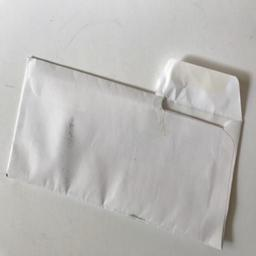

In [14]:
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model


save_dir = '/content/drive/MyDrive/Colab Notebooks/raw/models'
model_path = os.path.join(save_dir, 'best_logistic_regression_model.joblib')
scaler_path = os.path.join(save_dir, 'scaler.joblib')
# label_map_path = os.path.join(save_dir, 'label_map.joblib') # Not strictly needed if class_names is loaded
class_names_path = os.path.join(save_dir, 'class_names.joblib')

# --- Load the necessary components ---
loaded_model = joblib.load(model_path)
print("Model loaded.")
loaded_scaler = joblib.load(scaler_path)
print("Scaler loaded.")
# loaded_label_map = joblib.load(label_map_path) # Load if you prefer map
loaded_class_names = joblib.load(class_names_path)
print(f"Class names loaded: {loaded_class_names}")

# --- Need the feature extractor model again ---
IMG_SIZE = (224, 224)
base_model_reload = MobileNetV2(weights='imagenet', include_top=False,
                                input_shape=IMG_SIZE + (3,), pooling='avg')
feature_extractor_model_reload = base_model_reload
feature_extractor_model_reload.trainable = False
print("Feature extractor reloaded.")

# --- Define the function to extract features (same as before) ---
def extract_features_single(img_path, model):
    try:
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        features = model.predict(img_preprocessed, verbose=0)
        return features.flatten()
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None



single_image_path = '/content/drive/MyDrive/Colab Notebooks/raw/images/paper/paper_00124.jpg'

# --- Predict ---
if os.path.exists(single_image_path):
    print(f"\nProcessing image: {single_image_path}")
    # 1. Extract features
    single_features = extract_features_single(single_image_path, feature_extractor_model_reload)

    if single_features is not None:
        # Reshape for scaler (needs 2D array)
        single_features_reshaped = single_features.reshape(1, -1)

        # 2. Scale features using the loaded scaler
        single_features_scaled = loaded_scaler.transform(single_features_reshaped)

        # 3. Predict using the loaded model
        prediction_probabilities = loaded_model.predict_proba(single_features_scaled)
        predicted_label_index = loaded_model.predict(single_features_scaled)[0]

        # 4. Get the class name
        predicted_class_name = loaded_class_names[predicted_label_index]

        # Display results
        print(f"\nPredicted Class Index: {predicted_label_index}")
        print(f"Predicted Class Name: {predicted_class_name}")
        print("\nPrediction Probabilities:")
        for i, class_name in enumerate(loaded_class_names):
            print(f"  {class_name}: {prediction_probabilities[0][i]:.4f}")

        # Optional: Display the image
        from IPython.display import Image, display
        display(Image(filename=single_image_path, width=200))
    else:
        print("Could not extract features from the image.")
else:
    print(f"Error: Image path not found - {single_image_path}")